In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager as fm
fm.findfont('Helvetica')

'/System/Library/Fonts/Helvetica.ttc'

In [2]:
linelist = pd.read_csv("../data/epi-data/epi-surveillance-data-cases-only-abridged.csv")
linelist

,StateID,County,SymptomOnsetDate,Serum1Collected,FirstSerumCollectionDate,DateOfDiagResults,CollectionToResultLag
0,16VI2002,Saint Thomas,2016-09-05,False,NaN,NaN,NaN
1,16VI2118,Saint Thomas,2016-09-02,False,NaN,NaN,NaN
2,16VI2167,Saint Thomas,2016-09-19,False,NaN,NaN,NaN
3,16VI24587,Saint Croix,2016-10-15,False,NaN,NaN,NaN
4,16VI24589,Saint Croix,2016-10-06,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1308,16VI0509,Saint Croix,2016-03-06,True,2016-03-14,2016-04-04,21.0
1309,16VI0566,Saint Croix,2016-03-07,True,2016-03-23,2016-04-26,34.0
1310,16VI0596,Saint Croix,2016-03-10,True,2016-03-24,2016-07-14,112.0
1311,16VI1806,Saint Thomas,2016-08-24,True,2016-09-01,unknown,NaN


In [3]:
#make an index that goes day by day from the first reported symptom onset date to the last one.
#these will be our "bins" for counting up the number of new cases per day.
day_index = pd.date_range(linelist["SymptomOnsetDate"].min(), linelist["SymptomOnsetDate"].max(), freq='d')

print(("There are {} days between the first case and last case in our dataset.").format(len(day_index)))
print(("The first case was recorded on {}.").format(min(day_index)))
print(("The last case was recorded on {}.").format(max(day_index)))

There are 507 days between the first case and last case in our dataset.
The first case was recorded on 2016-01-03 00:00:00.
The last case was recorded on 2017-05-23 00:00:00.


In [4]:
#to make the epi curve we need to transform the linelist into counts of number of cases that happened on a day
#the df below has a record for every date that had a recorded case, but DOES NOT have a record for a date where no
#cases were detected. Which means that this df doesn't contain every date in the range the way the index df above does.
case_counts_per_day = pd.DataFrame(linelist["SymptomOnsetDate"].value_counts().sort_index())

,SymptomOnsetDate
2016-01-03,1
2016-01-06,1
2016-01-10,2
2016-01-22,1
2016-01-24,1
...,...
2017-05-14,1
2017-05-16,1
2017-05-18,2
2017-05-19,1


In [20]:
#then, make those above case counts contiguous with the full range of dates between the first and last case.
#this in essence fits the daily case counts into the date range index, filling in 0's for dates that had no cases.

empty_curve = case_counts_per_day.reindex(day_index).fillna(0) #make df for every day in range, set case counts at 0
all_islands_epi_curve_daily = empty_curve.add(case_counts_per_day).fillna(0) #add case counts from actual data if date has cases
#rename the columns so the names actually make sense.
all_islands_epi_curve_daily

,SymptomOnsetDate
2016-01-03,1.0
2016-01-04,0.0
2016-01-05,0.0
2016-01-06,1.0
2016-01-07,0.0
...,...
2017-05-19,1.0
2017-05-20,0.0
2017-05-21,0.0
2017-05-22,0.0


In [21]:
#sometimes rather than having case counts per day we want case counts per week,
#so here I've just grouped the case counts from days into weeks.
#the date represents the END of the week. So for the case count represented by 2016-01-10,
#that case count represents all cases that happened between 2016-01-04 up to end of day 2016-01-10.
#in this case there's 3, because there was a case on 2016-01-06 and two on 2016-01-10.
all_islands_epi_curve_weekly = all_islands_epi_curve_daily.resample('W', closed="right").sum()
all_islands_epi_curve_weekly

,EndOfWeekDate,CaseCount
0,2016-01-03,1.0
1,2016-01-10,3.0
2,2016-01-17,0.0
3,2016-01-24,2.0
4,2016-01-31,3.0
...,...,...
69,2017-04-30,4.0
70,2017-05-07,3.0
71,2017-05-14,2.0
72,2017-05-21,4.0


In [22]:
#change the column names so that they make sense and 
#write these files out to CSVs for later use if I want.
#note that I'm changing headers RIGHT before I'm writing to file because I actually need the index objects
#for the transformations that I did earlier.

all_islands_epi_curve_daily.reset_index(inplace=True)
all_islands_epi_curve_daily = all_islands_epi_curve_daily.rename(columns = {"index": "Date", "SymptomOnsetDate":"CaseCount"})
all_islands_epi_curve_daily.to_csv("../data/epi-data/daily_incidence_all_islands.csv")

all_islands_epi_curve_weekly.reset_index(inplace=True)
all_islands_epi_curve_weekly = all_islands_epi_curve_weekly.rename(columns = {"index":"EndOfWeekDate", "SymptomOnsetDate": "CaseCount"})
all_islands_epi_curve_weekly.to_csv("../data/epi-data/weekly_incidence_all_islands.csv")


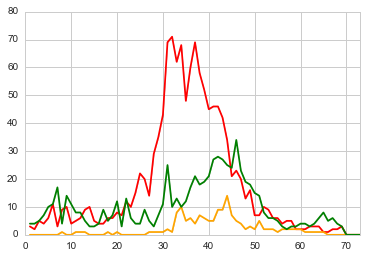

In [38]:
sns.set_style("whitegrid")
sns.tsplot(data=caribbean_df['St. Thomas'], color='red')
sns.tsplot(data=caribbean_df['St. John'], color = 'orange')
sns.tsplot(data=caribbean_df['St. Croix'], color = 'green')